In [2]:
import torch
from torch.utils.tensorboard import SummaryWriter

from data import artificial_1D_linear as data
from experiments.artificial_1D_linear.documentation import (
    evaluate,
    get_logging_dir,
    plot_data_split,
    plot_predictions,
)
from models import SmartAverageLayer

from experiments.artificial_1D_linear.smart_fed_avg_util import (
    train_client,
    register_client_test_losses,
)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
NUM_CLIENTS = 2

COMMUNICATION_ROUNDS = 10
CLIENT_EPOCHS = 100

SPLIT_TYPE = "interval"

In [4]:
CLIENT_IDs = range(NUM_CLIENTS)

BATCH_SIZE = 64

INPUT_FEATURES = 1
OUTPUT_FEATURES = 1
ARCHITECTURE = [11, 12, 11, 12]

LOSS_FN = torch.nn.MSELoss()

In [5]:
def register_hyperparameters(writer, last_loss):
    writer.add_hparams(
        {
            "client_epochs": CLIENT_EPOCHS,
            "num_clients": NUM_CLIENTS,
            "communication_rounds": COMMUNICATION_ROUNDS,
            "split_type": SPLIT_TYPE,
            "architecture": str(ARCHITECTURE),
        },
        {
            "MSE Test": last_loss,
        },
        run_name=".",
    )

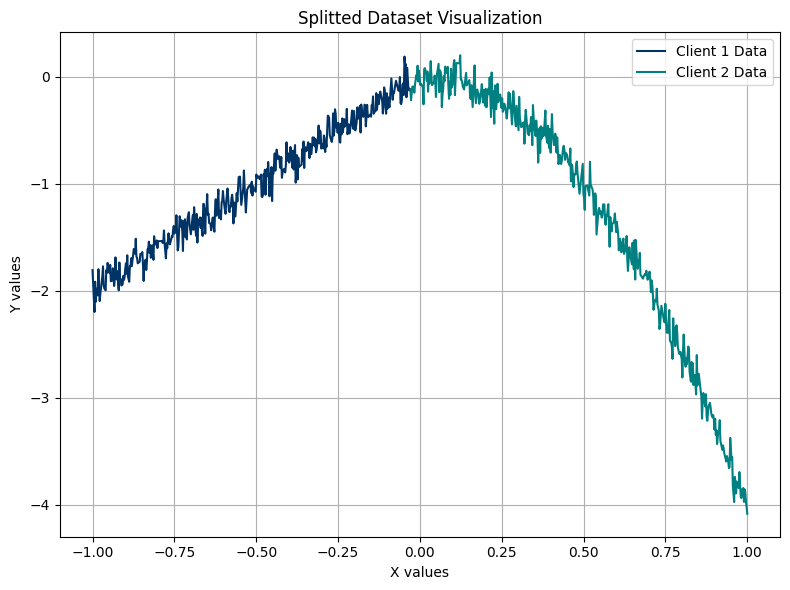

In [6]:
model_name = f"MyFed_{NUM_CLIENTS}clients_{SPLIT_TYPE}-split"
writer = SummaryWriter(get_logging_dir(model_name))

clients = [
    SmartAverageLayer.from_scratch(INPUT_FEATURES, OUTPUT_FEATURES, NUM_CLIENTS, client_id, ARCHITECTURE)
    for client_id in CLIENT_IDs
]

client_train_dataloaders = data.get_client_test_dataloaders(
    NUM_CLIENTS, SPLIT_TYPE, BATCH_SIZE, shuffle=True
)

plot_data_split(client_train_dataloaders, writer)

In [7]:
print(clients[0])

SmartAverageLayer(
  (prediction_network): MultiOutputNet(
    (activation): ReLU()
    (hidden_layers): ModuleList(
      (0): Linear(in_features=2, out_features=11, bias=False)
      (1): Linear(in_features=12, out_features=12, bias=False)
      (2): Linear(in_features=13, out_features=11, bias=False)
      (3): Linear(in_features=12, out_features=12, bias=False)
    )
    (output_layers): ModuleList(
      (0-1): 2 x Linear(in_features=13, out_features=1, bias=False)
    )
    (output_scalings): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1]
        (1): Parameter containing: [torch.float32 of size 1]
    )
  )
)


Communication Round 9/10
 global model:  SmartAverageLayer(
  (prediction_network): MultiOutputNet(
    (activation): ReLU()
    (hidden_layers): ModuleList(
      (0): Linear(in_features=2, out_features=15, bias=False)
      (1): Linear(in_features=16, out_features=42, bias=False)
      (2): Linear(in_features=43, out_features=48, bias=False)
      (3): Linear(in_features=49, out_features=68, bias=False)
    )
    (output_layers): ModuleList(
      (0-1): 2 x Linear(in_features=69, out_features=1, bias=False)
    )
    (output_scalings): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1]
        (1): Parameter containing: [torch.float32 of size 1]
    )
  )
)

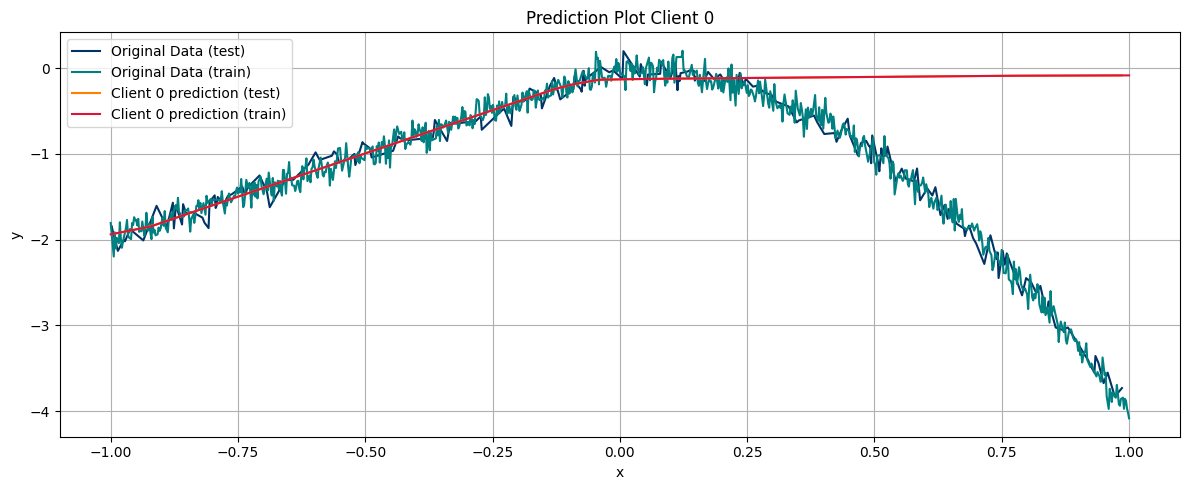

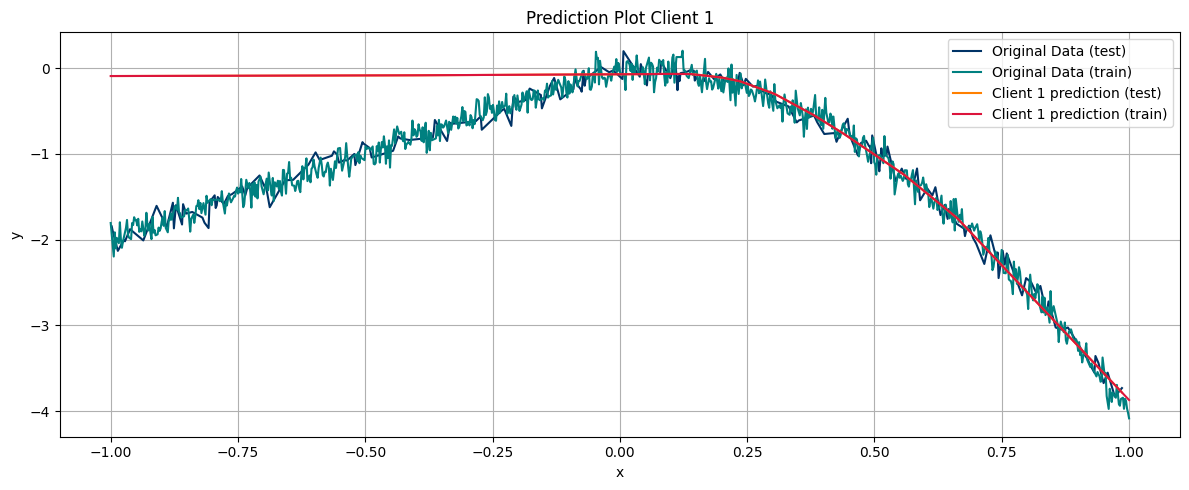

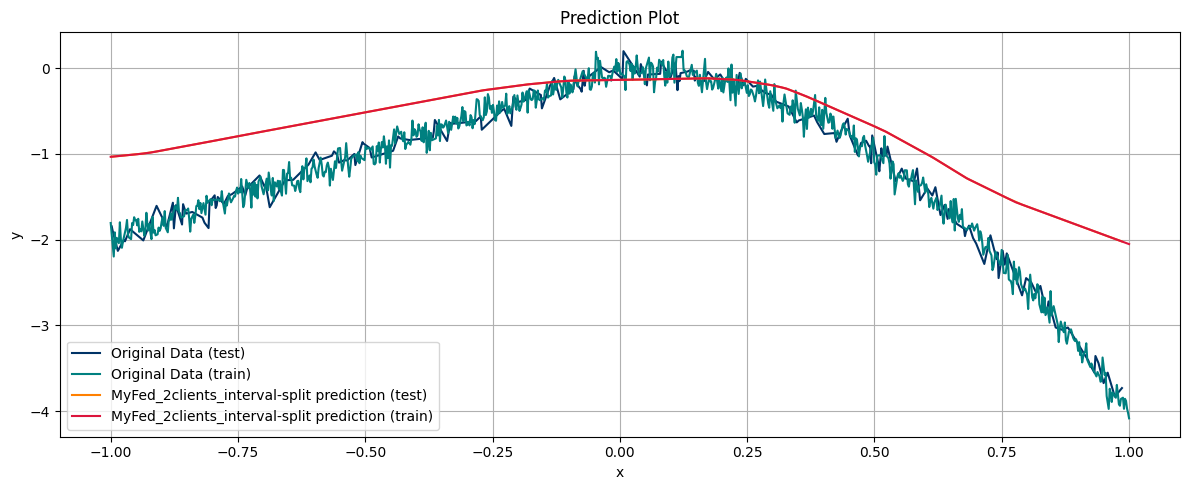

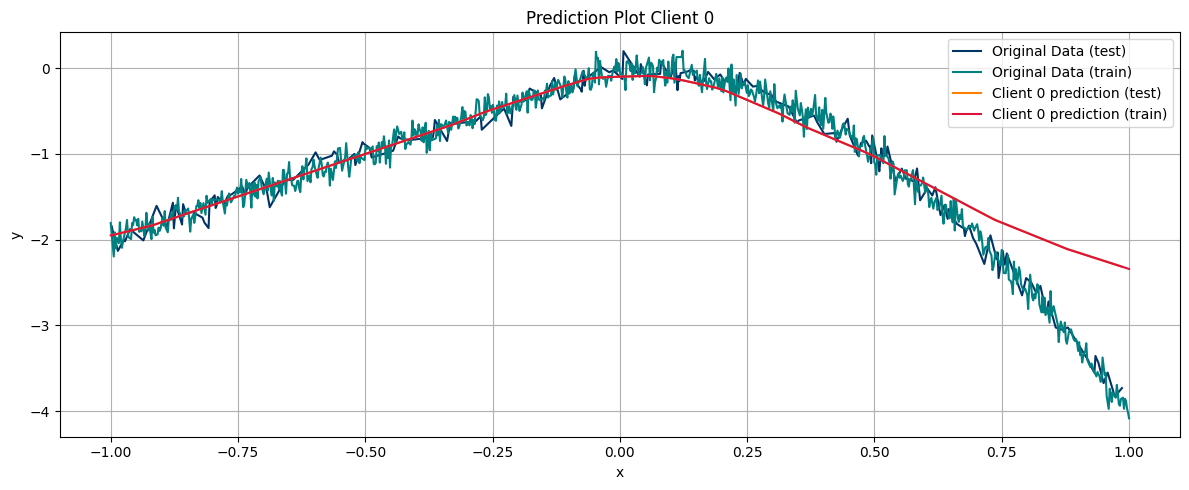

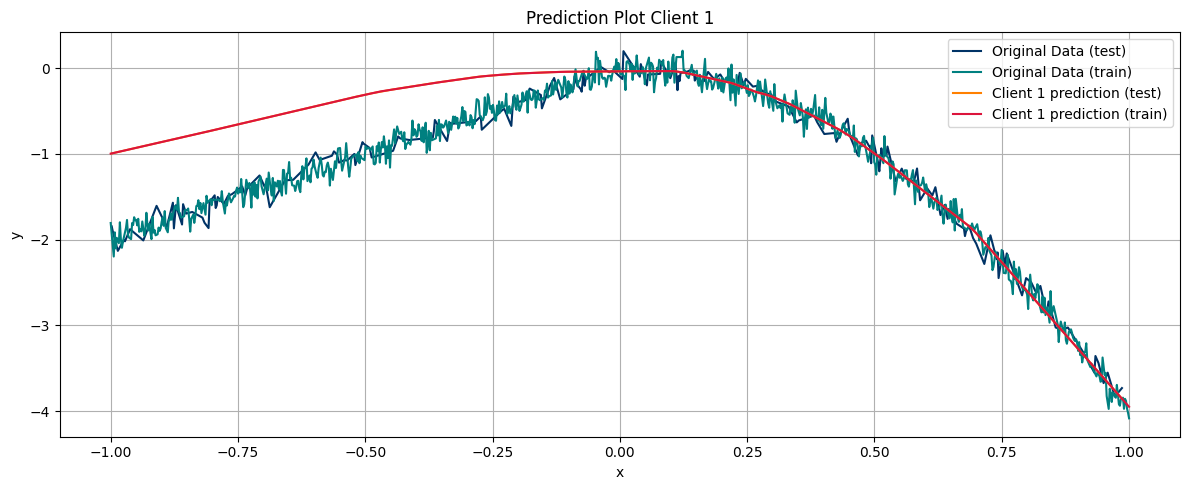

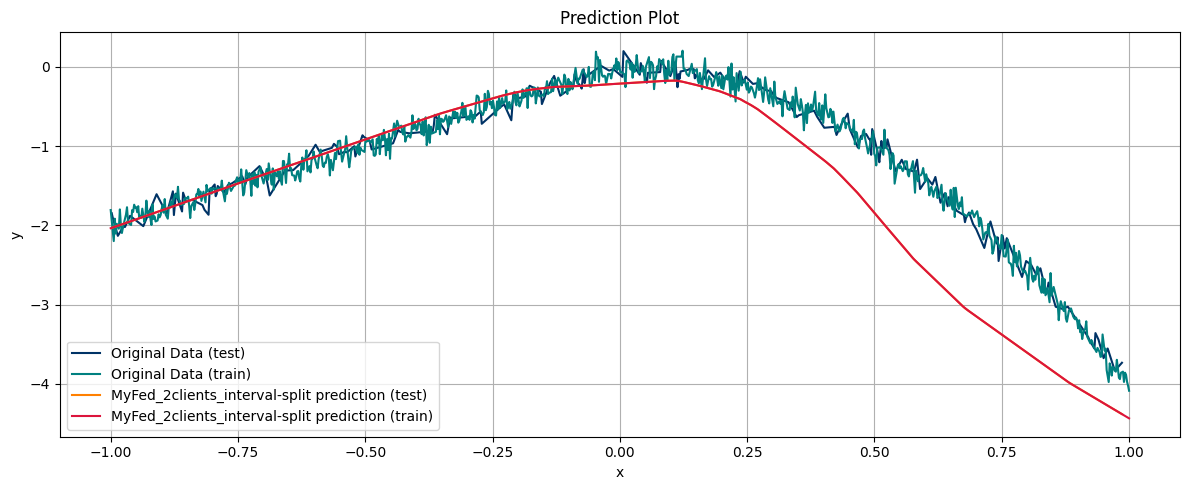

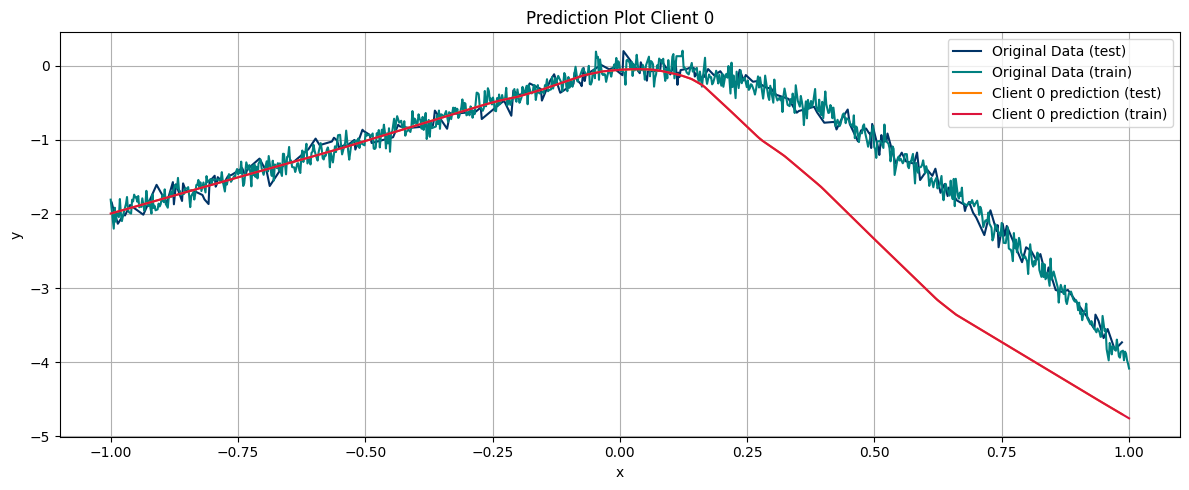

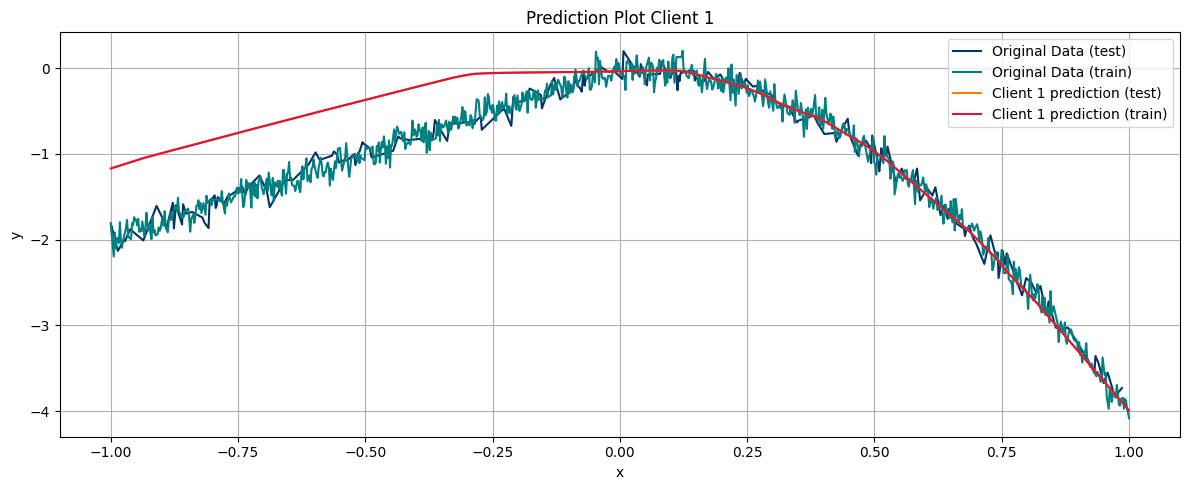

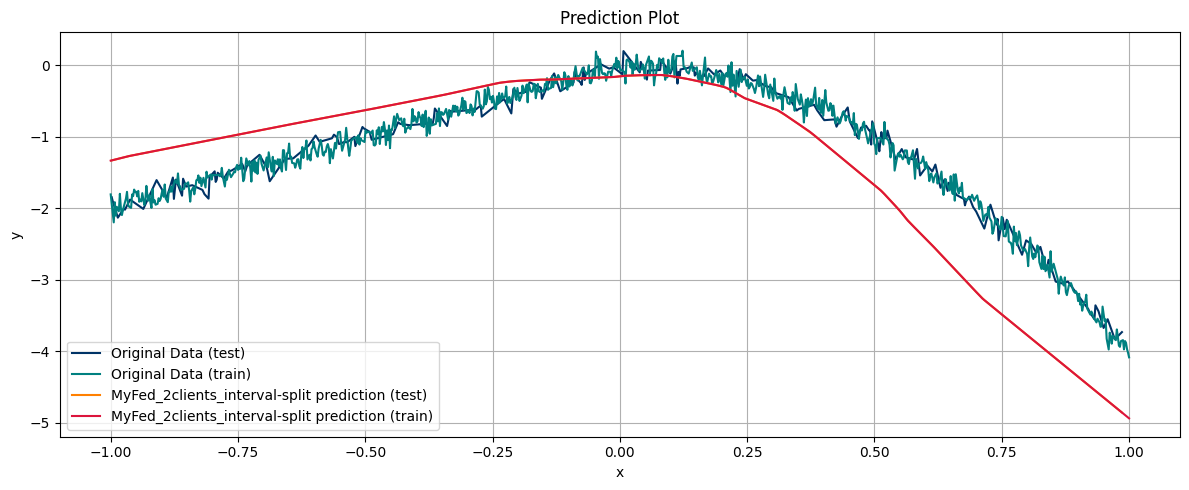

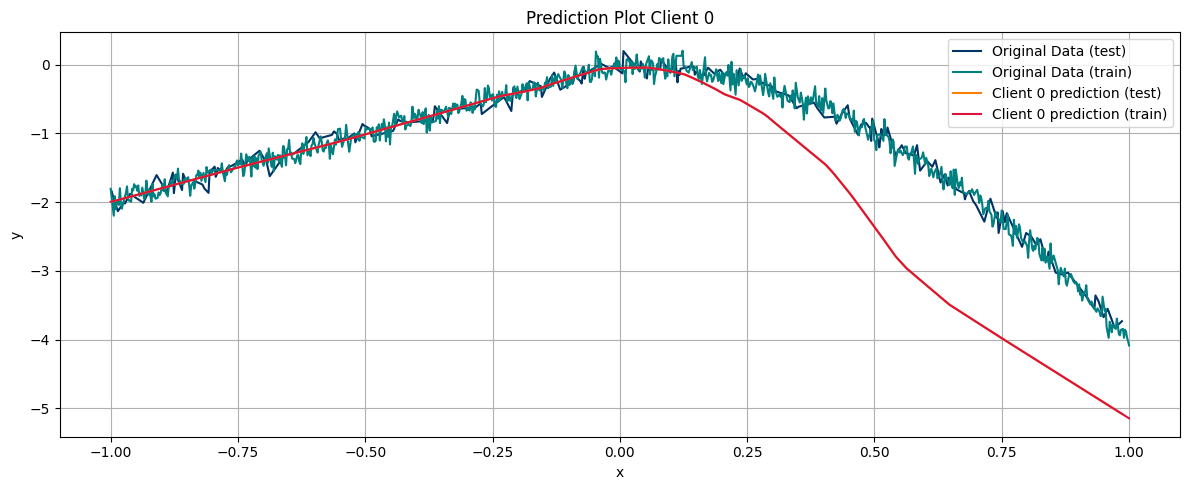

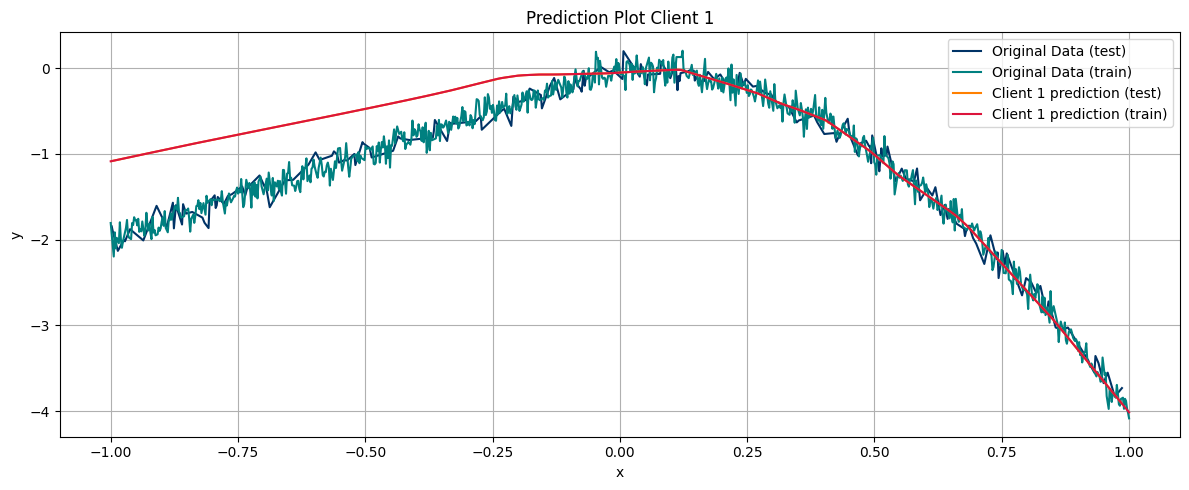

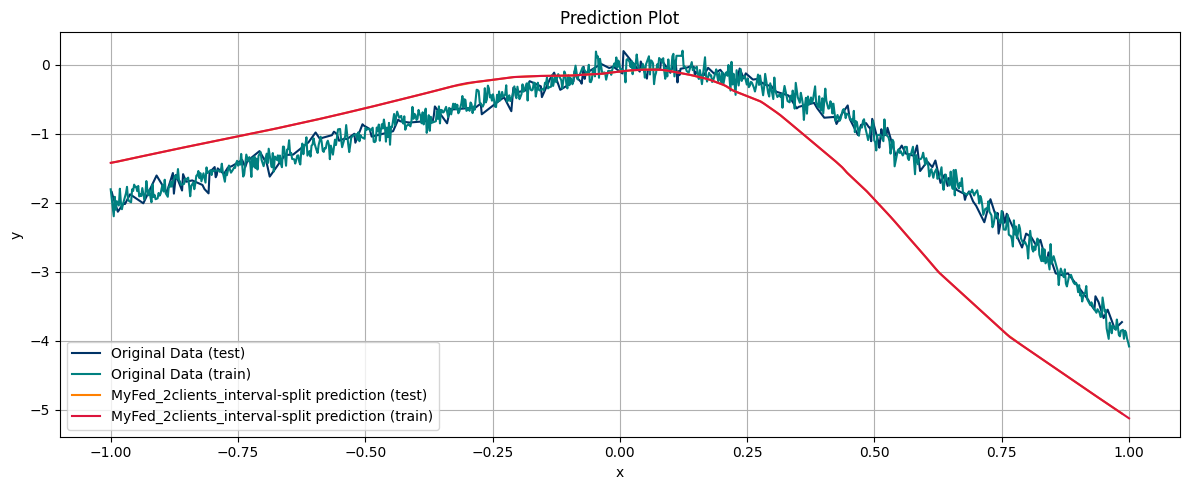

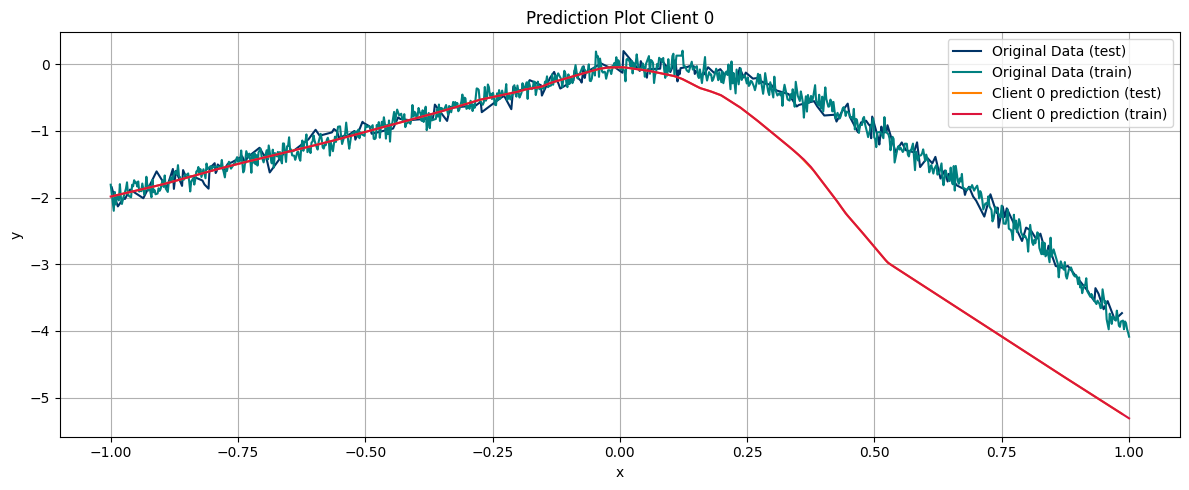

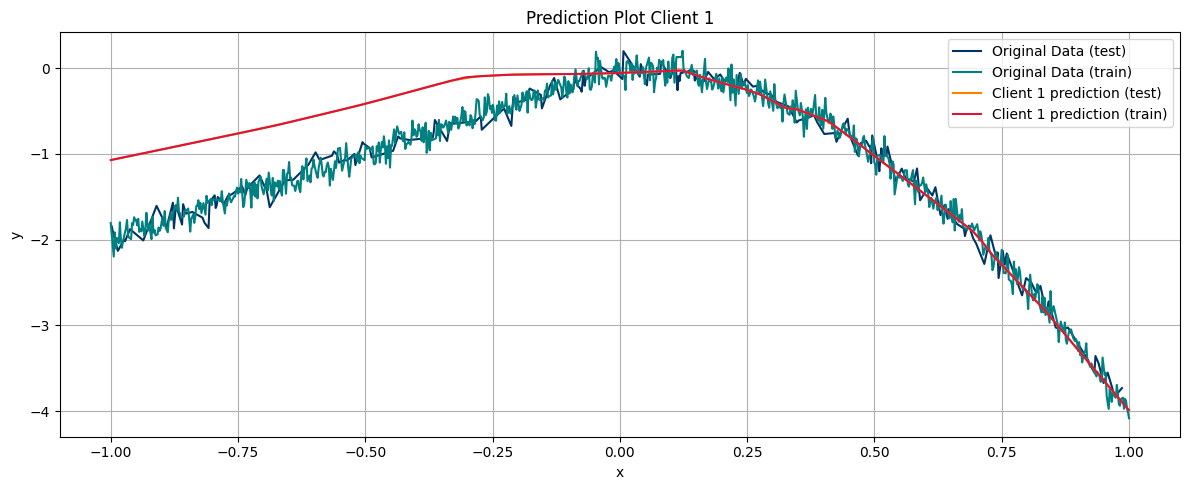

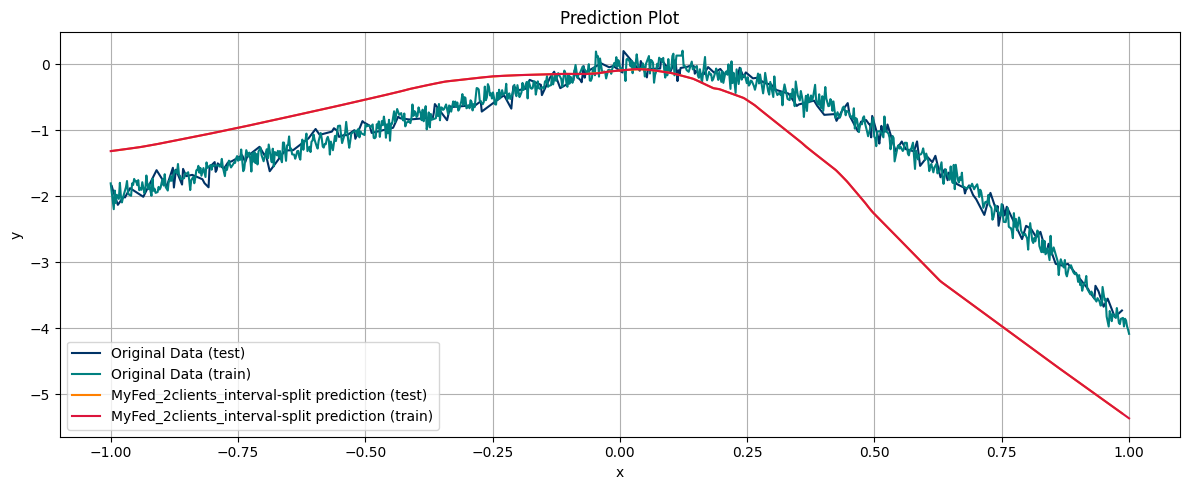

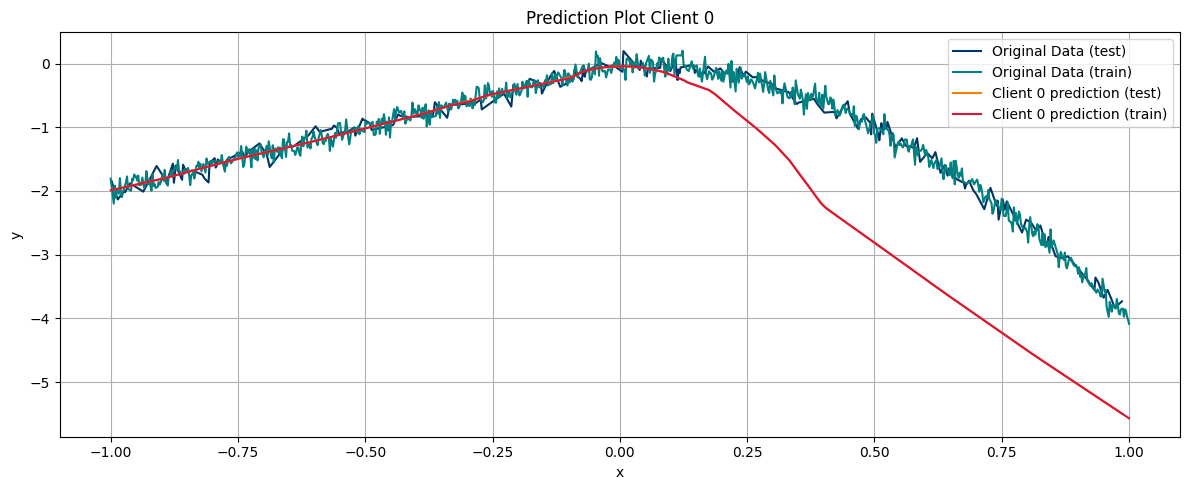

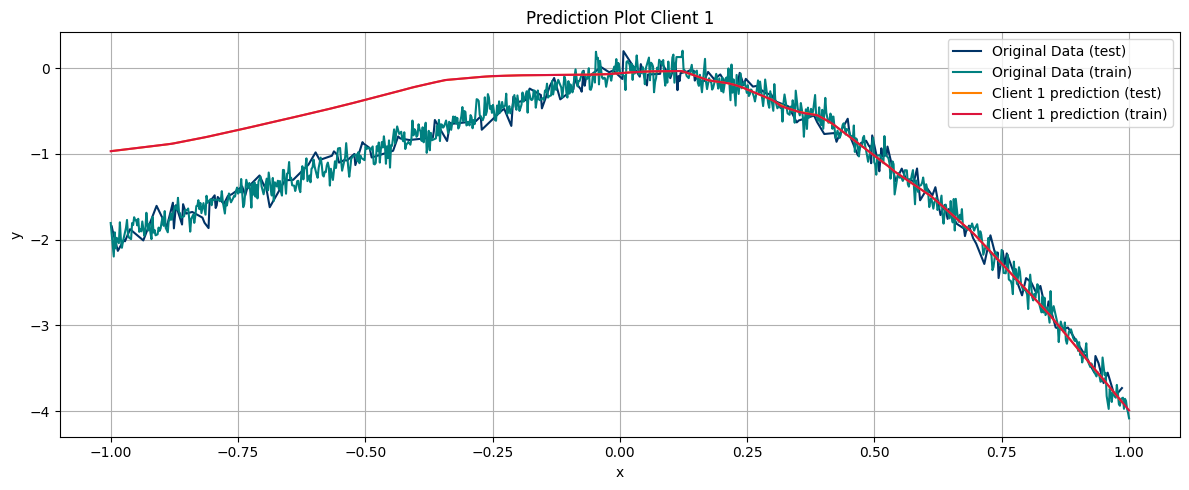

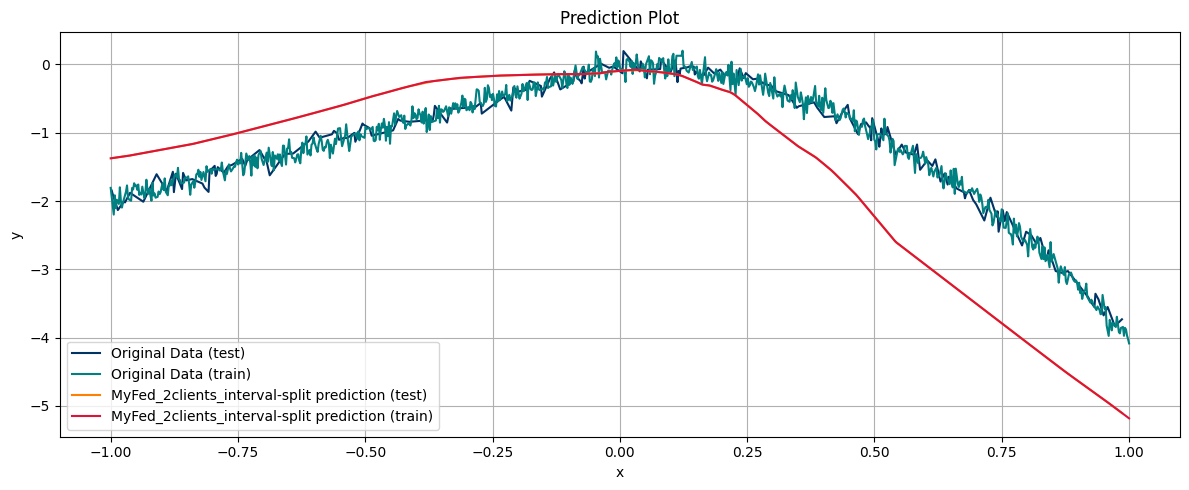

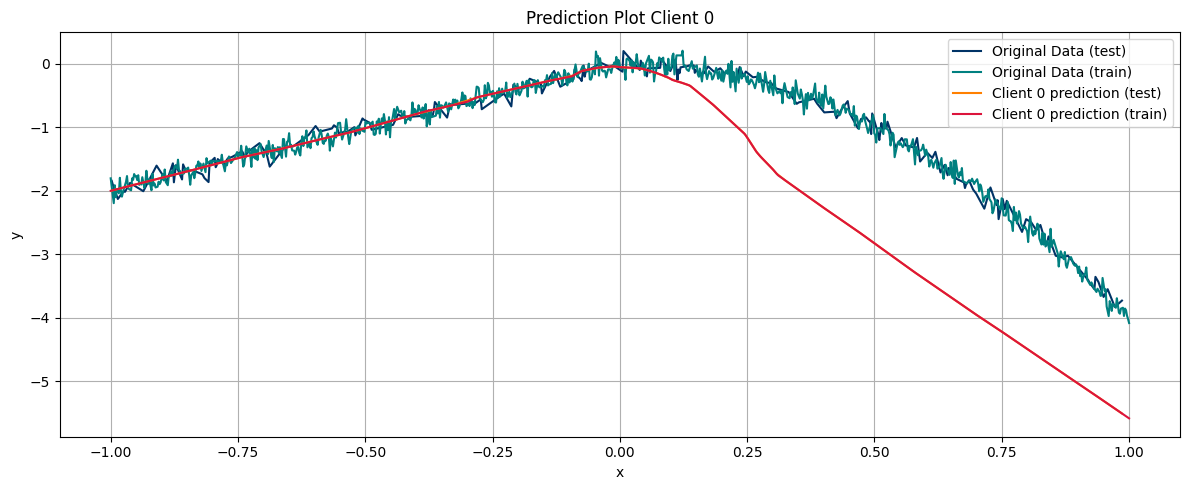

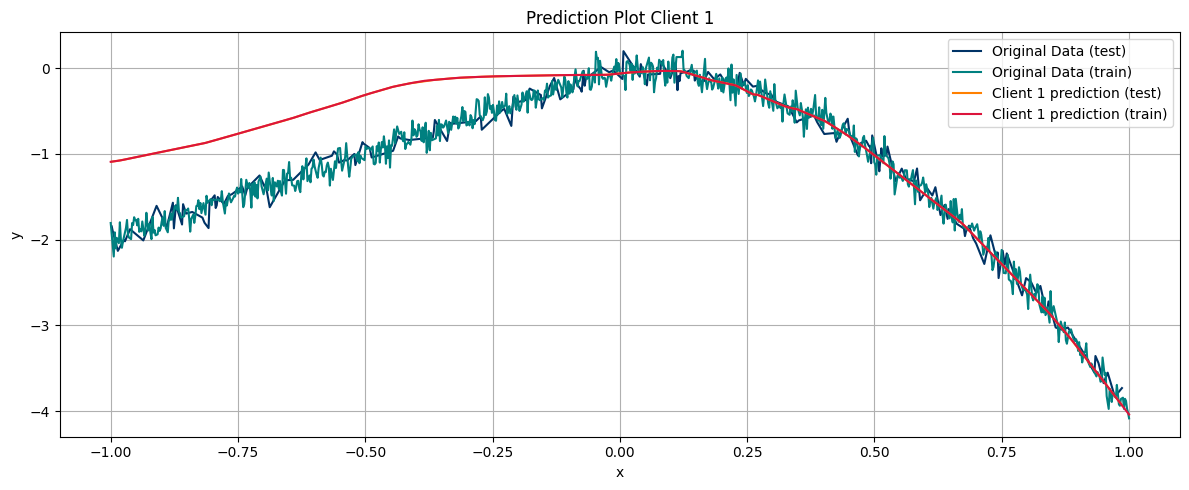

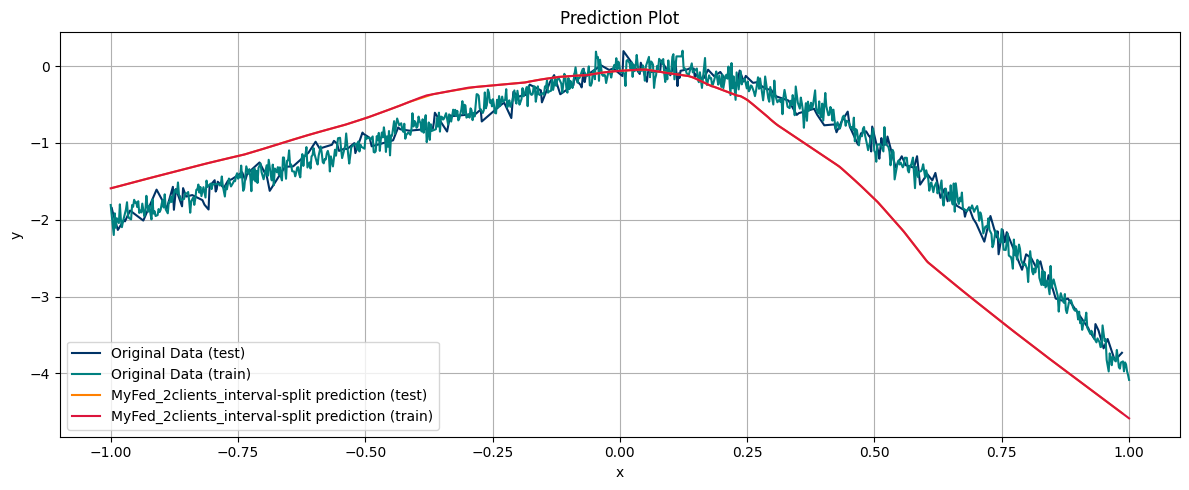

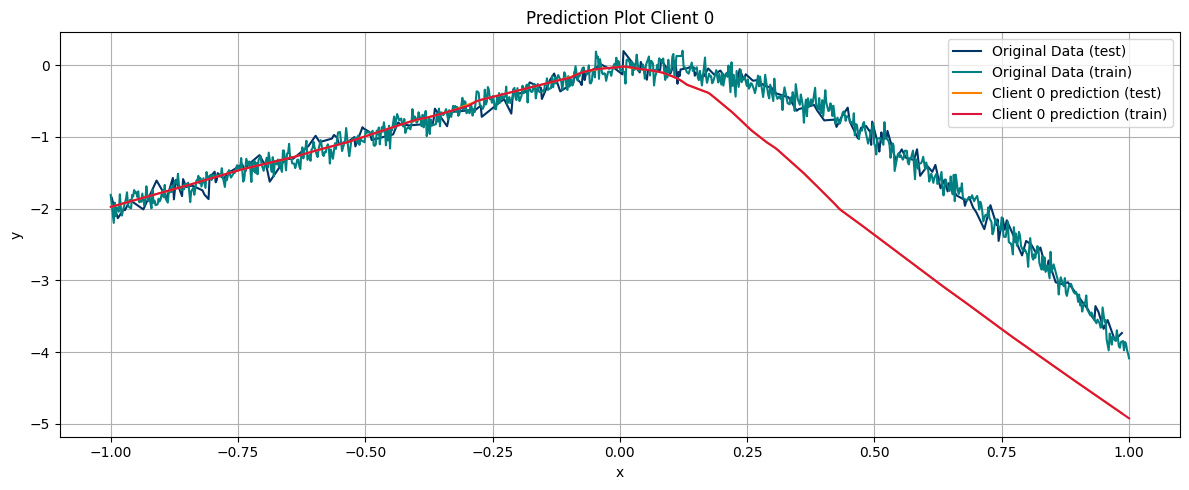

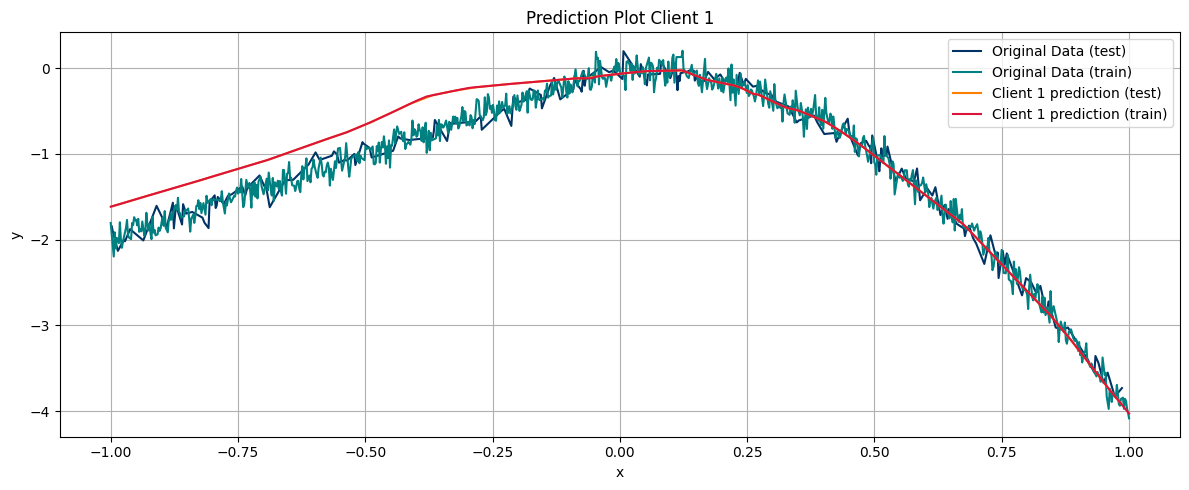

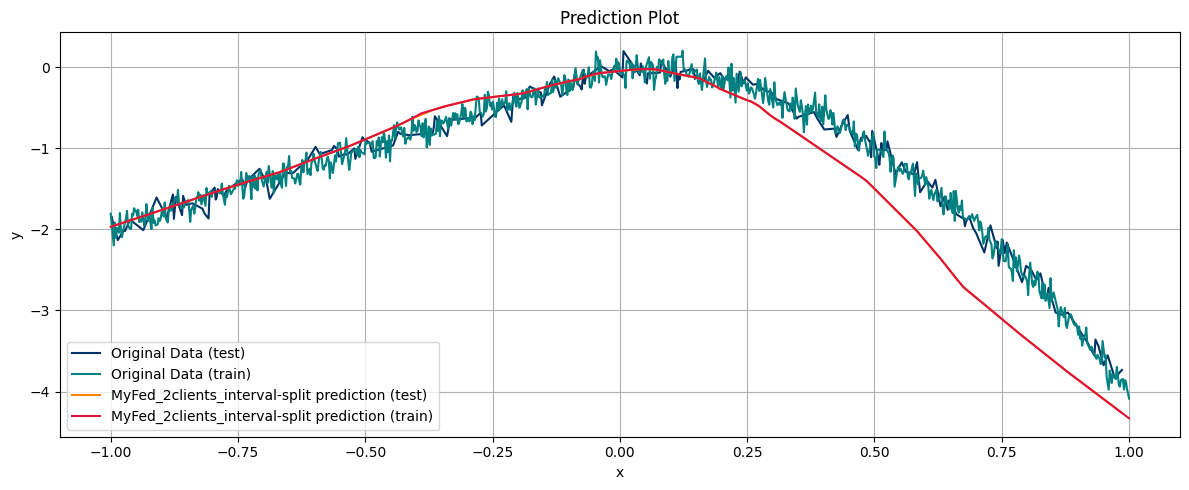

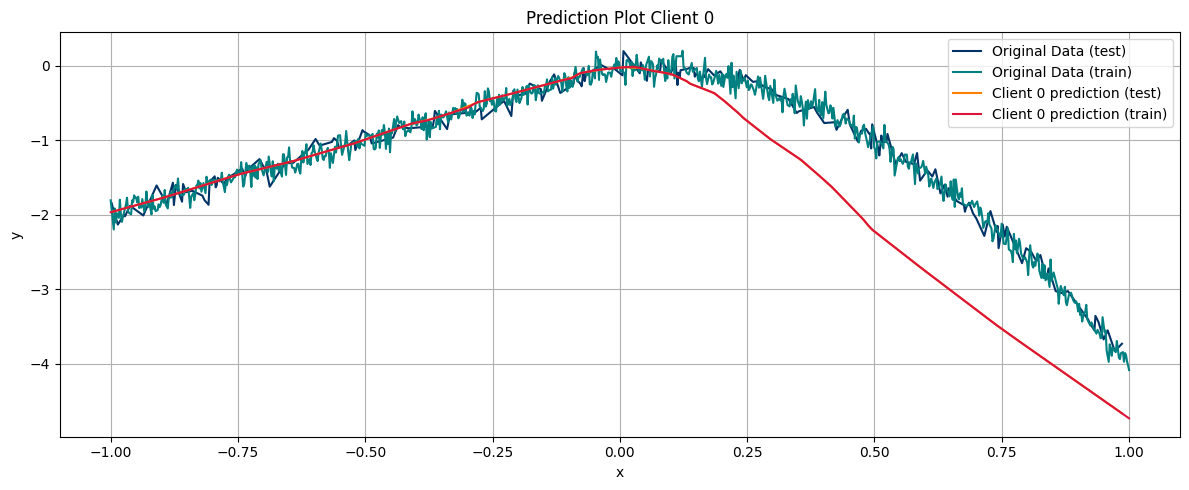

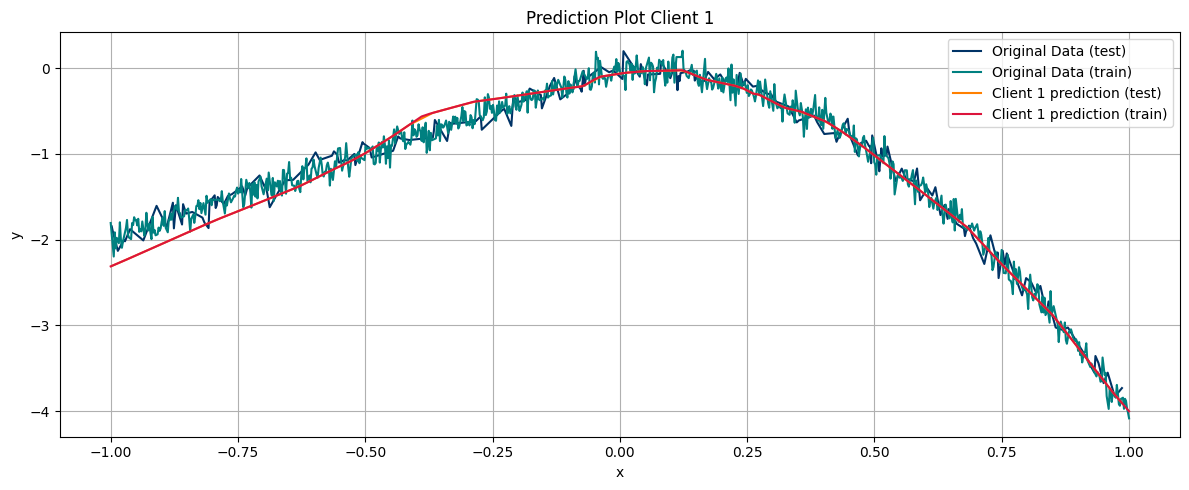

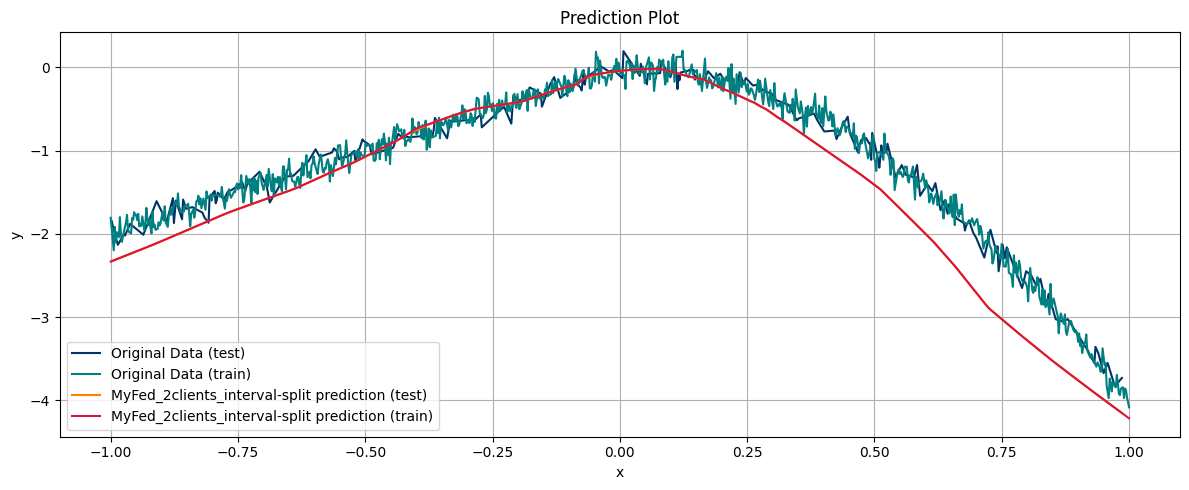

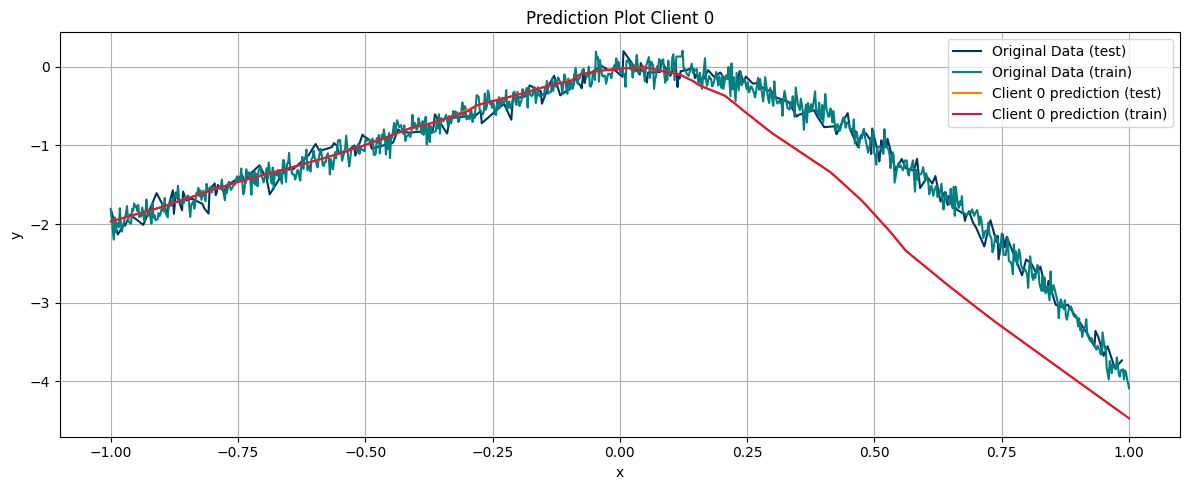

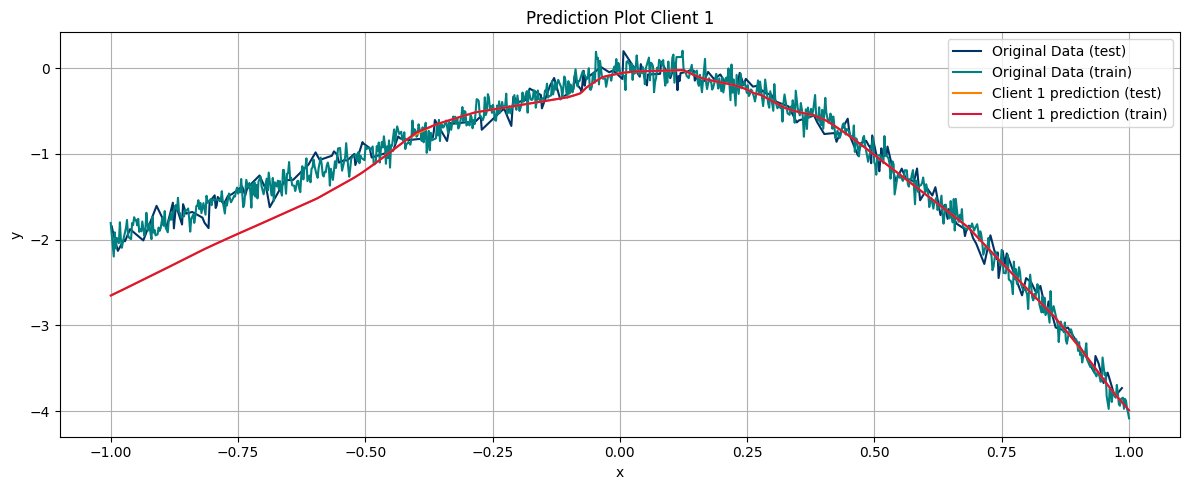

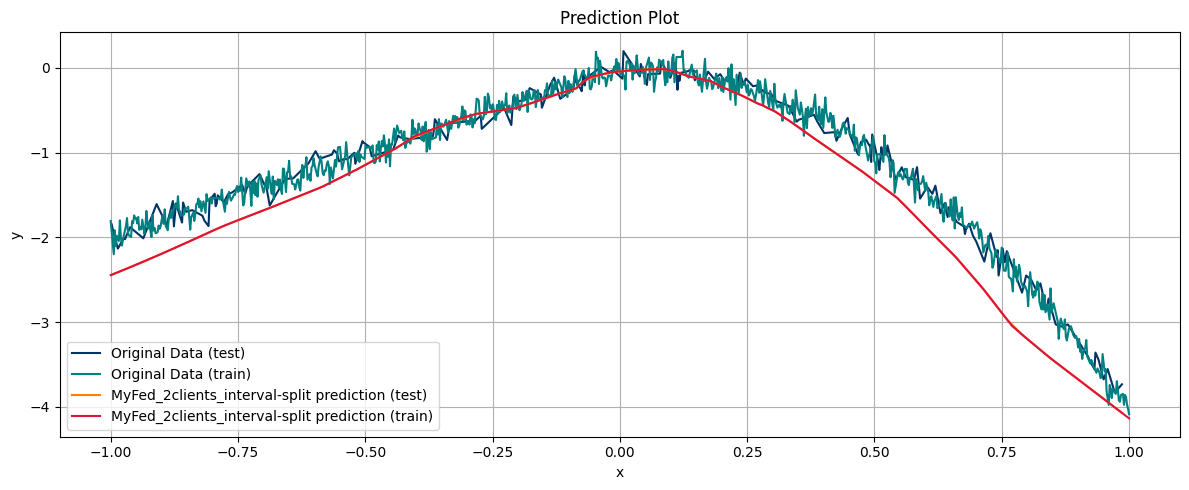

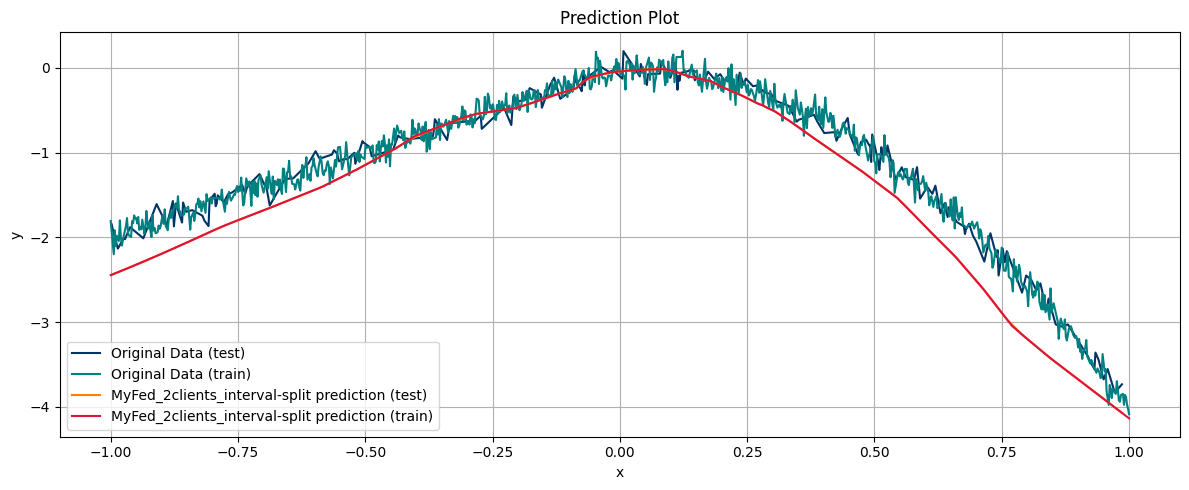

In [8]:
def is_cooling_off_epoch(cr: int):
    return cr > COMMUNICATION_ROUNDS // 2


for cr in range(COMMUNICATION_ROUNDS):
    # train each client individually
    for client_no, client in zip(CLIENT_IDs, clients):
        train_client(
            client_no=client_no,
            client_model=client,
            data_loader=client_train_dataloaders[client_no],
            loss_fn=LOSS_FN,
            no_epochs=CLIENT_EPOCHS,
            communication_round=cr,
            writer=writer,
        )

    register_client_test_losses(
        clients=clients, client_ids=CLIENT_IDs, writer=writer, communication_round=cr
    )

    global_model = SmartAverageLayer.get_global_model(
        clients,
        similarity_threshold_in_degree=30 if not is_cooling_off_epoch(cr) else 181,
        add_noise=(not is_cooling_off_epoch(cr)),
    )

    writer.add_scalar("test_loss", evaluate(global_model), cr * CLIENT_EPOCHS)

    #### ----- Unimportant ----- NOTE: remove####################################################################################
    from IPython.display import clear_output

    clear_output(wait=True)
    print(f"Communication Round {cr}/{COMMUNICATION_ROUNDS}")
    print("\r global model: ", global_model, end="")
    # print("\n\n GLOBAL MODEL\n", list(global_model.named_parameters()))

    #### //// ----- Unimportant ------------------------------------------------------------------------------------------------

    clients = [global_model.get_client_model(client_id) for client_id in CLIENT_IDs]

    plot_predictions(global_model, model_name, writer, epoch=cr)

plot_predictions(global_model, model_name, writer)
register_hyperparameters(writer, last_loss=evaluate(global_model))
writer.close()

In [9]:
print(global_model.prediction_network.full_representation())
print(global_model.prediction_mask)

SelfLearningNet Weights: (training on output None)
Layer 0 Weights:
[[ 9.5777947e-01  2.8748724e-01]
 [-8.4527487e-01  5.3433180e-01]
 [-7.0953751e-01 -7.0466769e-01]
 [-6.9503322e-02 -9.9758172e-01]
 [-7.5755125e-01 -6.5277570e-01]
 [-4.2919743e-01  9.0321004e-01]
 [-1.2442668e-01 -9.9222028e-01]
 [-3.7429386e-01 -9.2730188e-01]
 [-2.7098122e-01 -9.6258247e-01]
 [ 9.9955505e-01 -4.2038038e-05]
 [ 9.9871546e-01  4.9518939e-02]
 [ 2.9627079e-01 -9.5505762e-01]
 [ 4.5810029e-01  8.8888752e-01]
 [-9.8505753e-01 -1.7222562e-01]
 [ 8.5561112e-02  9.9628842e-01]]
Layer 1 Weights:
[[ 0.1780774  -0.35609466 -0.5173893   0.08733469 -0.48394102  0.15246266
  -0.12670927  0.06260368 -0.08929314 -0.05711152 -0.13575995  0.27368706
  -0.37107122 -0.08542957  0.02295296  0.19653948]
 [ 0.03277252 -0.02707295 -0.09387029 -0.03537668 -0.0171137  -0.00096341
   0.19262606 -0.09755234 -0.28014153 -0.4206358  -0.03931094  0.03660206
  -0.09628511  0.18711784  0.05532423  0.79470897]
 [ 0.17048664  0.1232

In [10]:
for client in clients:
    print(client.prediction_network.full_representation())
    print(client.prediction_mask)

SelfLearningNet Weights: (training on output 0)
Layer 0 Weights:
[[ 9.5777947e-01  2.8748724e-01]
 [-8.4527487e-01  5.3433180e-01]
 [-7.0953751e-01 -7.0466769e-01]
 [-6.9503322e-02 -9.9758172e-01]
 [-7.5755125e-01 -6.5277570e-01]
 [-4.2919743e-01  9.0321004e-01]
 [-1.2442668e-01 -9.9222028e-01]
 [-3.7429386e-01 -9.2730188e-01]
 [-2.7098122e-01 -9.6258247e-01]
 [ 9.9955505e-01 -4.2038038e-05]
 [ 9.9871546e-01  4.9518939e-02]
 [ 2.9627079e-01 -9.5505762e-01]
 [ 4.5810029e-01  8.8888752e-01]
 [-9.8505753e-01 -1.7222562e-01]
 [ 8.5561112e-02  9.9628842e-01]]
Layer 1 Weights:
[[ 0.1780774  -0.35609466 -0.5173893   0.08733469 -0.48394102  0.15246266
  -0.12670927  0.06260368 -0.08929314 -0.05711152 -0.13575995  0.27368706
  -0.37107122 -0.08542957  0.02295296  0.19653948]
 [ 0.03277252 -0.02707295 -0.09387029 -0.03537668 -0.0171137  -0.00096341
   0.19262606 -0.09755234 -0.28014153 -0.4206358  -0.03931094  0.03660206
  -0.09628511  0.18711784  0.05532423  0.79470897]
 [ 0.17048664  0.1232173